# Backtesting MACD Strategies

## Getting the Data

In [1]:
import sys
sys.path.append('../../')

In [2]:
from config.constants import *
from backtesting import Backtest, Strategy
from backtesting.test import EURUSD, SMA
from backtesting.lib import plot_heatmaps, resample_apply
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from util.ATR import *
from util.SMA import *
from util.plot_return import *
from util.Bollinger_bands import *
from util.load_data import *

In [3]:
XAUUSD = load_data()

In [7]:
XAUUSD['D1']

,Open,High,Low,Close,Volume
Time,,,,,
2007-01-01,635.679,637.103,635.006,635.943,604
2007-01-02,635.791,640.802,635.286,639.143,1282
2007-01-03,639.029,644.663,624.634,626.602,1302
2007-01-04,626.699,630.352,619.600,622.533,1365
2007-01-05,622.268,625.768,601.591,606.841,1284
...,...,...,...,...,...
2023-03-06,1852.255,1858.168,1845.015,1846.255,1380
2023-03-07,1846.225,1851.555,1812.655,1813.865,1380
2023-03-08,1813.855,1824.185,1809.248,1815.175,1379


In [9]:
XAUUSD['D1'].info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5043 entries, 2007-01-01 to 2023-03-10
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    5043 non-null   float64
 1   High    5043 non-null   float64
 2   Low     5043 non-null   float64
 3   Close   5043 non-null   float64
 4   Volume  5043 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 236.4 KB


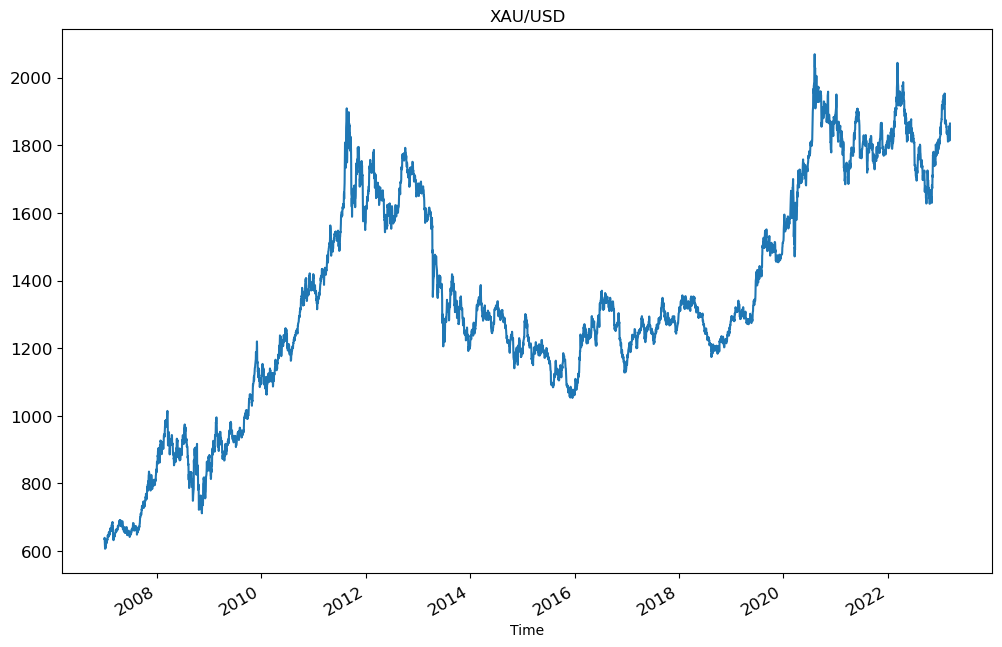

In [12]:
XAUUSD['D1'].Close.plot(figsize=(12, 8), title="XAU/USD", fontsize=12)
plt.show()

## Definde strategy

In [13]:
class MACD(Strategy):
    ema_s = 12  # EMA Short
    ema_l = 26  # EMA Long
    signal_mw = 9  # Moving Window for Signal Line

    def init(self):
        self.data.df["EMA_S"] = self.data.df['Close'].ewm(
            span=self.ema_s, min_periods=self.ema_s).mean()
        self.data.df["EMA_L"] = self.data.df['Close'].ewm(
            span=self.ema_l, min_periods=self.ema_l).mean()
        self.data.df["MACD"] = self.data.df["EMA_S"] - self.data.df["EMA_L"]
        self.data.df["MACD_Signal"] = self.data.df["MACD"].ewm(
            span=self.signal_mw, min_periods=self.signal_mw).mean()

    def next(self):
        if self.data.df["MACD"].iloc[-1] > self.data.df["MACD_Signal"].iloc[-1] and not self.position.is_long:
            if self.position.is_short :
                self.position.close()
            # Place your buy logic here
            self.buy(size=1)

        if self.data.df["MACD"].iloc[-1] < self.data.df["MACD_Signal"].iloc[-1] and not self.position.is_short:
            if self.position.is_long:
                self.position.close()
            self.sell(size=1)

## Backtesting

In [14]:
account_size = 20000

In [15]:
bt = Backtest(XAUUSD['H4'], MACD, cash=account_size, margin=1/2000, )
result = bt.run()
result

Start                     2007-01-01 00:00:00
End                       2023-03-10 16:00:00
Duration                   5912 days 16:00:00
Exposure Time [%]                    99.86911
Equity Final [$]                    22145.365
Equity Peak [$]                     22515.466
Return [%]                          10.726825
Buy & Hold Return [%]              193.329158
Return (Ann.) [%]                    0.510475
Volatility (Ann.) [%]                0.971367
Sharpe Ratio                         0.525523
Sortino Ratio                        0.797681
Calmar Ratio                         0.222186
Max. Drawdown [%]                   -2.297516
Avg. Drawdown [%]                   -0.134007
Max. Drawdown Duration     2021 days 20:00:00
Avg. Drawdown Duration       22 days 14:00:00
# Trades                                 1974
Win Rate [%]                        37.740628
Best Trade [%]                      11.531394
Worst Trade [%]                     -5.458385
Avg. Trade [%]                    

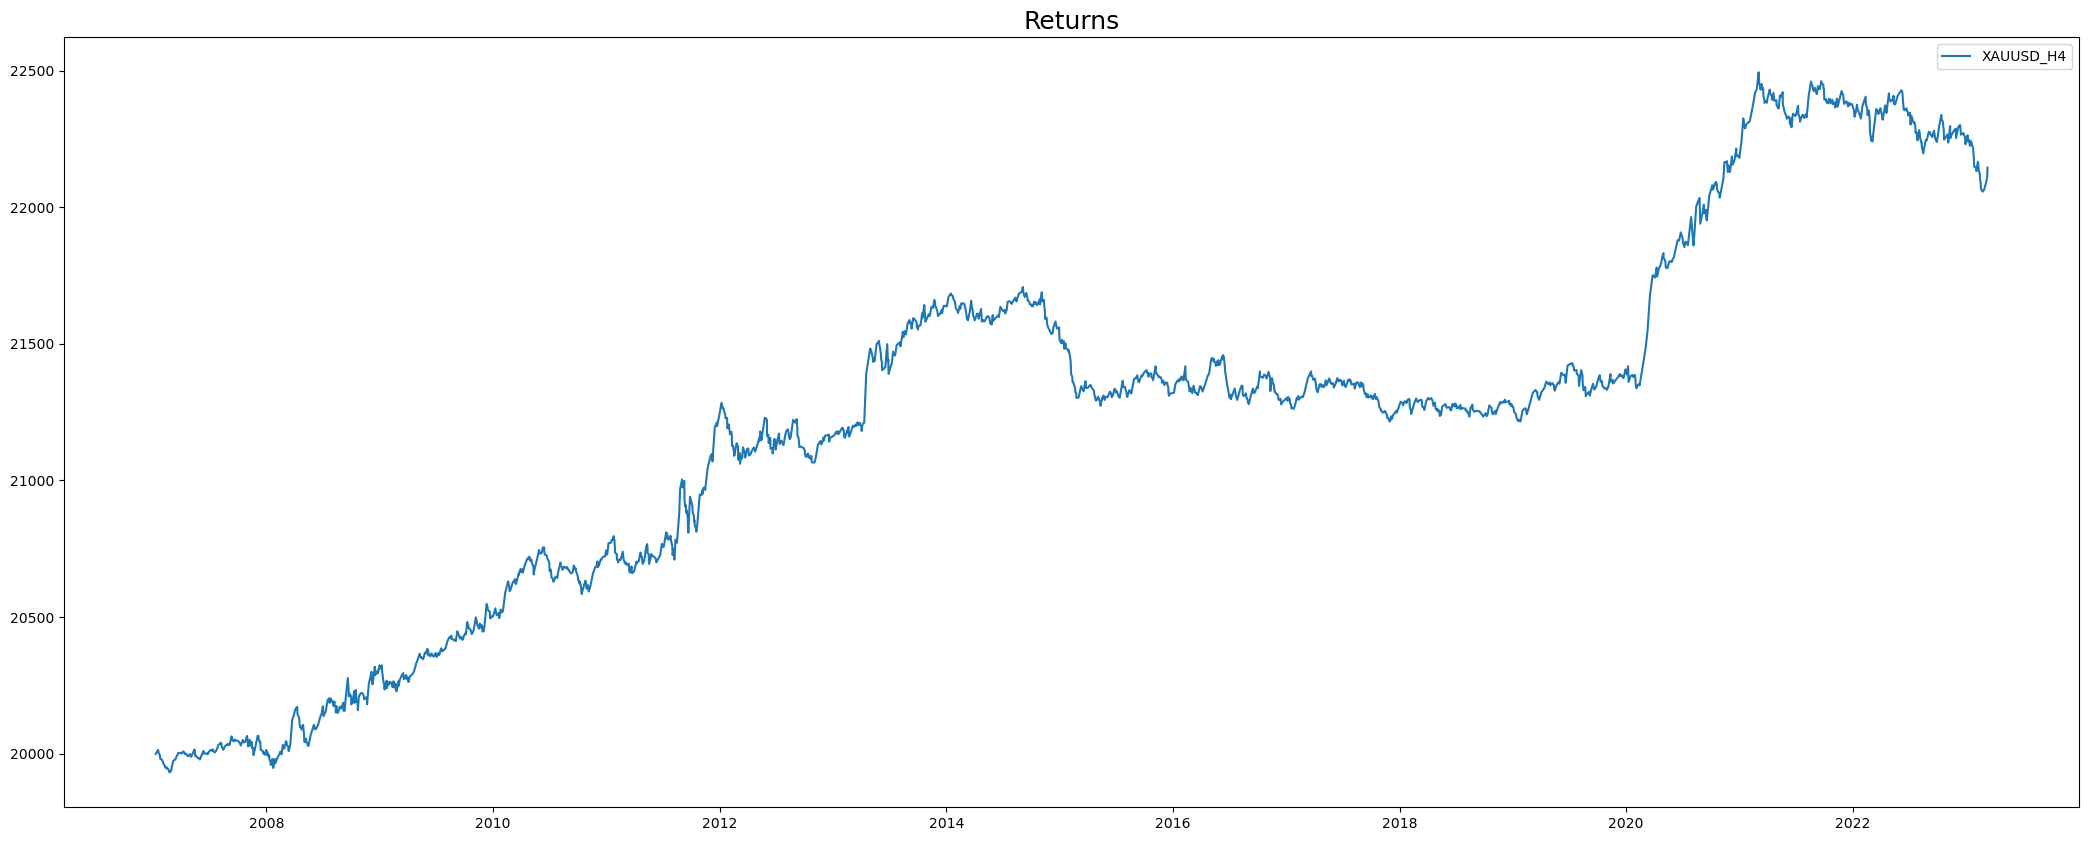

In [16]:
plot_return_trades(result['_trades'], 'XAUUSD_H4' , account_size)

In [18]:
bt.plot()

c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:119: UserWarning: Data contains too many candlesticks to plot; downsampling to '1D'. See `Backtest.plot(resample=...)`
  warnings.warn(f"Data contains too many candlesticks to plot; downsampling to {freq!r}. "
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and will raise in a future version. Use index.get_indexer([item], method=...) instead.
  new_bar_idx = new_index.get_loc(mean_time, method='nearest')
c:\Users\Win10\anaconda3\lib\site-packages\backtesting\_plotting.py:145: FutureWarning: Passing method to Int64Index.get_loc is deprecated and w

Row(id='2427', ...)